In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import display

In [2]:
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

In [3]:
df_cite = pd.read_csv("citeseer/adjacency.tsv", sep='\t', header=None)
display(df_cite.head())

,0,1,2
0,0,869,True
1,1,326,True
2,1,597,True
3,1,669,True
4,1,794,True


In [4]:
df_flight = pd.read_csv("openflights/adjacency.tsv", sep='\t', header=None)
display(df_flight.head())

,0,1,2
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,2
4,1,0,1


In [5]:
print("\n---OpenFlights Positions---")
df_pos = pd.read_csv("openflights/position.tsv", sep='\t', header=None)
display(df_pos.head())


---OpenFlights Positions---


,0,1
0,145.391998,-6.081690
1,145.789001,-5.207080
2,144.296005,-5.826790
3,146.725977,-6.569803
4,147.220001,-9.443380


In [6]:
def haversine(lon1, lat1, lon2, lat2):
    # Calculates physical distance (km) afor openflights dataset.
    # to use "Gravity Models" for flight data
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * asin(sqrt(a)) * 6371

In [7]:
def sample_negatives(G, k, rng):
    # randomly samples 'Non-Edges' to balance the dataset
    neg = set()
    nodes = list(G.nodes())
    while len(neg) < k:
        u, v = rng.choice(nodes, 2, replace=False)
        if not G.has_edge(u, v):
            neg.add(tuple(sorted((u, v))))
    return list(neg)

In [ ]:
def compute_features(G, u, v, pos_dict=None):

    has = G.has_edge(u, v)
    
    # 1. degree 
    deg_u = G.degree(u) - (1 if has else 0)
    deg_v = G.degree(v) - (1 if has else 0)
    
    # 2.Triadic Closure
    Nu = set(G.neighbors(u)) - {v}
    Nv = set(G.neighbors(v)) - {u}
    cn = len(Nu & Nv) # Common Neighbors
    
    union = len(Nu | Nv)
    jacc = cn / union if union > 0 else 0.0 # Jaccard Coefficient
    
    # 3. Adamic-Adar 
    adamic = 0.0
    for z in (Nu & Nv):
        dz = G.degree(z)
        if dz > 1:
            adamic += 1.0 / np.log(dz)
            
    # 4. Spatial Feature (only for OpenFlights)
    dist = -1.0
    if pos_dict and (u in pos_dict) and (v in pos_dict):
        lat1, lon1 = pos_dict[u]
        lat2, lon2 = pos_dict[v]
        dist = haversine(lon1, lat1, lon2, lat2)
        
    return [deg_u, deg_v, cn, jacc, adamic, dist]

In [9]:
def build_Xy(G, pairs, pos_dict, label):
    X = [compute_features(G, u, v, pos_dict) for (u, v) in pairs]
    y = [label] * len(X)
    return np.array(X), np.array(y)

In [10]:
def get_negatives(G, count, rng):
    ne = set()
    nodes = list(G.nodes())
    while len(ne) < count:
        u, v = rng.choice(nodes, size=2, replace=False)
        if not G.has_edge(u, v):
            ne.add(tuple(sorted((u, v))))
    return list(ne)

In [11]:
def build_Xy(G, pairs, pos_dict, label):
    X = [compute_features(G, u, v, pos_dict) for (u, v) in pairs]
    y = [label] * len(X)
    return np.array(X), np.array(y)

In [12]:
def conformal_quantile(scores, alpha):
    # Calculates the (1-alpha) quantile
    # Formula: ceil((n+1)(1-alpha)) / n
    q = np.quantile(scores, np.ceil((len(scores) + 1) * (1 - alpha)) / len(scores))
    return q

In [18]:
from sklearn.metrics import precision_recall_fscore_support # Ensure this is imported

def run_pipeline(adj_path, pos_path=None, name="dataset", alpha=0.10):
    print(f"\n{'='*30}\nRunning Pipeline: {name.upper()}\n{'='*30}")
    
    # A. Load Graph
    # Using 'usecols=[0,1]' to Source/Target, ignoring weights for now
    df = pd.read_csv(adj_path, sep='\t', header=None, usecols=[0,1], names=['u','v'])
    G = nx.from_pandas_edgelist(df, source='u', target='v').to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    
    pos = {}
    if pos_path:
        dfp = pd.read_csv(pos_path, sep='\t', header=None)
        for i, row in dfp.iterrows():
            pos[i] = (row.iloc[-2], row.iloc[-1])
    
    # Uniform Sampling 
    # shuffle edges 
    edges = list(G.edges())
    rng.shuffle(edges)
    
    n = len(edges)
    n_cal = int(n * 0.1)
    n_test = int(n * 0.1)
    
    E_cal = edges[:n_cal]
    E_test = edges[n_cal:n_cal + n_test]
    E_train = edges[n_cal + n_test:]
    
    # Create masked for train data
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(E_train)
    
    # creating non edges
    print("Sampling negatives and building features...")
    NE_cal = sample_negatives(G, len(E_cal), rng)
    NE_test = sample_negatives(G, len(E_test), rng)
    NE_train = sample_negatives(G, len(E_train), rng)
    
    # feature Mmatrices
    X_tr_pos, y_tr_pos = build_Xy(G_train, E_train, pos, 1)
    X_tr_neg, y_tr_neg = build_Xy(G_train, NE_train, pos, 0)
    X_train = np.vstack([X_tr_pos, X_tr_neg])
    y_train = np.hstack([y_tr_pos, y_tr_neg])
    
    X_cal_pos, y_cal_pos = build_Xy(G_train, E_cal, pos, 1)
    X_cal_neg, y_cal_neg = build_Xy(G_train, NE_cal, pos, 0)
    X_cal = np.vstack([X_cal_pos, X_cal_neg])
    y_cal = np.hstack([y_cal_pos, y_cal_neg])
    
    X_te_pos, y_te_pos = build_Xy(G_train, E_test, pos, 1)
    X_te_neg, y_te_neg = build_Xy(G_train, NE_test, pos, 0)
    X_test = np.vstack([X_te_pos, X_te_neg])
    y_test = np.hstack([y_te_pos, y_te_neg])
    
    print("Training model")
    clf = GradientBoostingClassifier(random_state=RNG_SEED)
    clf.fit(X_train, y_train)
    
    # get probabilities
    p_cal = clf.predict_proba(X_cal)[:, 1]
    p_test = clf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, p_test)

    y_pred_std = (p_test >= 0.5).astype(int)
    _, _, base_f1, _ = precision_recall_fscore_support(y_test, y_pred_std, average='binary', zero_division=0)
    
    # Conformal Calibration 
    # calibrate Class 0 and Class 1 separately (Mondrian CP)
    scores_pos = 1 - p_cal[y_cal == 1] #Score for Real Edges (1)
    scores_neg = p_cal[y_cal == 0]     #Score for Non Edges (0)
    
    q1 = conformal_quantile(scores_pos, alpha)
    q0 = conformal_quantile(scores_neg, alpha)
    
    # thresholds
    t_upper = 1 - q1
    t_lower = q0
    
    print(f"-> Thresholds: Accept 0 if p <= {t_lower:.3f}, Accept 1 if p >= {t_upper:.3f}")
    
    # Evaluate
    sets = []
    for p in p_test:
        s = set()
        if p <= t_lower: s.add(0)
        if p >= t_upper: s.add(1)
        if len(s) == 0: s = {0, 1} # Abstain if uncertain
        sets.append(s)
        
    coverage = np.mean([y in s for y, s in zip(y_test, sets)])
    abstention = np.mean([len(s) > 1 for s in sets])

    decided_idx = [i for i, S in enumerate(sets) if len(S) == 1]
    if decided_idx:
        y_dec_true = y_test[decided_idx]
        y_dec_pred = [list(sets[i])[0] for i in decided_idx]
        _, _, f1_dec, _ = precision_recall_fscore_support(y_dec_true, y_dec_pred, average='binary', zero_division=0)
    else:
        f1_dec = 0.0
    
    print(f"\nRESULTS ({name.upper()}):")
    print(f"AUC: {auc:.4f} ")
    print(f"Base F1: {base_f1:.4f} (Standard Classifier)")
    print(f"Coverage: {coverage:.4f} (Target: {1-alpha}) -> {'VALID' if coverage >= 1-alpha else 'INVALID'}")
    print(f"Abstention: {abstention:.4f} ")
    print(f"Decided F1: {f1_dec:.4f}")
    
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, p_test)
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}", color='green')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {name.upper()}")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.histplot(p_test[y_test==0], label='Non-Edge (0)', color='red', alpha=0.3, kde=True, bins=30)
    sns.histplot(p_test[y_test==1], label='Edge (1)', color='blue', alpha=0.3, kde=True, bins=30)
    plt.axvline(t_lower, color='red', linestyle='--', linewidth=2, label='Threshold 0')
    plt.axvline(t_upper, color='blue', linestyle='--', linewidth=2, label='Threshold 1')
    plt.xlabel("Predicted Probability")
    plt.title("Conformal Thresholds & Distribution")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        "name": name, 
        "auc": float(auc), 
        "base_f1": float(base_f1),
        "coverage": float(coverage), 
        "abstention": float(abstention),
        "decided_f1": float(f1_dec)
    }


Running Pipeline: CITESEER
Sampling negatives and building features...
Training model
-> Thresholds: Accept 0 if p <= 0.579, Accept 1 if p >= 0.244

RESULTS (CITESEER):
AUC: 0.8665 
Base F1: 0.7890 (Standard Classifier)
Coverage: 0.9249 (Target: 0.9) -> VALID
Abstention: 0.4029 
Decided F1: 0.8885


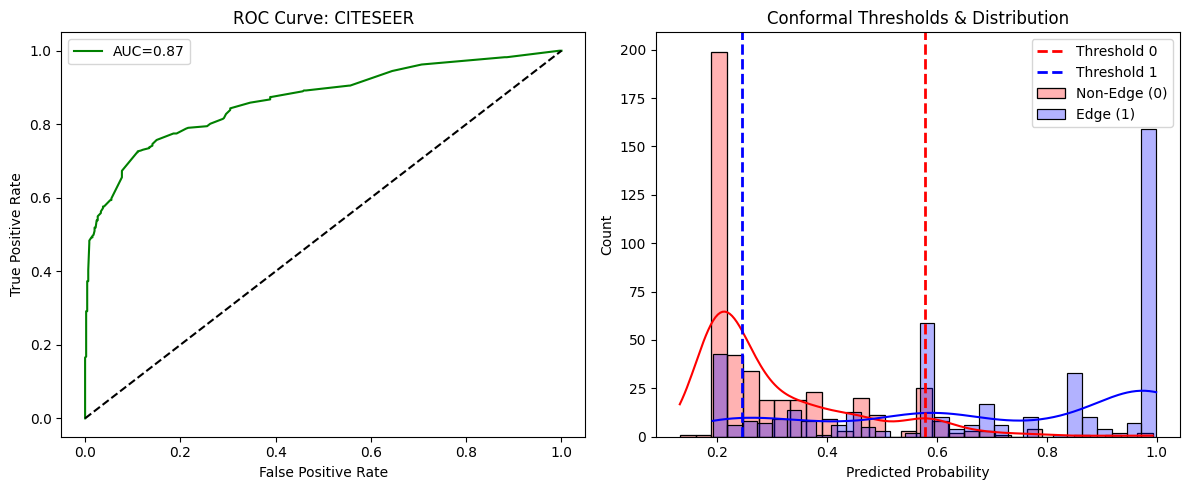

In [19]:
res_cite = run_pipeline("citeseer/adjacency.tsv", pos_path=None, name="citeseer")



Running Pipeline: OPENFLIGHTS
Sampling negatives and building features...
Training model
-> Thresholds: Accept 0 if p <= 0.051, Accept 1 if p >= 0.886

RESULTS (OPENFLIGHTS):
AUC: 0.9912 
Base F1: 0.9646 (Standard Classifier)
Coverage: 0.9879 (Target: 0.9) -> VALID
Abstention: 0.0910 
Decided F1: 0.9867


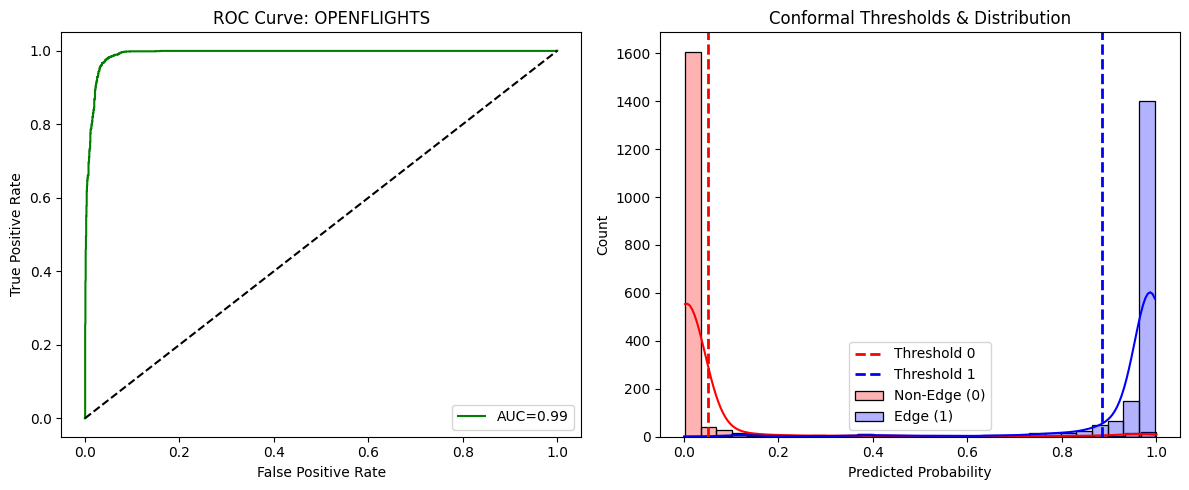

In [20]:
res_flight = run_pipeline("openflights/adjacency.tsv", pos_path="openflights/position.tsv", name="openflights")
